In [1]:
import json
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tqdm import tqdm
import random
import numpy as np

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
merchant_id = '14FAEC7E2D3BEE13'

In [4]:
file = '/data/predict/'+merchant_id+'/'+merchant_id+'_logs.json'

In [5]:
users = {}
with open(file, encoding='utf8') as f:
    for line in tqdm(f):
        data = json.loads(line)
        if data['visitor_id'] not in users:
            users[data['visitor_id']] = []
        for prod_idx in data['viewed_products']:
            try:
                users[data['visitor_id']].append(prod_idx)
            except ValueError: 
                print('Sktrain_labelsiped ' + prod_idx)

858541it [00:06, 125921.56it/s]


In [6]:
users_lens = list(map(lambda x: len(x), users.values()))

In [7]:
print(len(users.keys()))

176329


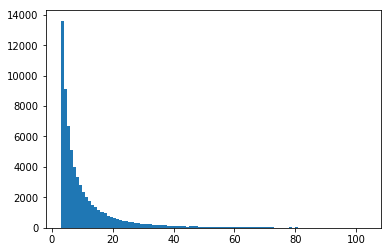

In [8]:
d = plt.hist(users_lens, bins=100, range=(3, 103))

In [9]:
products = {}
for u in users.values():
    for pid in u:
        products[pid] = 1
product_idxs = products.keys()
product_ids = {v: k for k, v in enumerate(product_idxs)}
number_of_classes = len(product_idxs)

In [10]:
print(number_of_classes)

6739


In [11]:
def dedup(seq):
    seen = set()
    seen_add = seen.add

    return [x for x in seq if not (x in seen or seen_add(x))]


users_with_product_idxs = {}
for uid,products in users.items():
    ids = dedup(list(map(lambda x: product_ids[x], products)))
    if len(ids) > 1:
        users_with_product_idxs[uid] = ids
    
del users

In [12]:
raw_data = []
raw_abels  = []
for uid,products in tqdm(users_with_product_idxs.items()):
    if(len(products) > 5):
        for i in range(len(products) - 6):
            if(random.random() < 1):
                raw_data.append(np.array(products[i:(i+5)]))
                raw_abels.append(np.array(products[(i+1):(i+6)]))

100%|██████████| 71706/71706 [00:00<00:00, 91793.68it/s] 


In [13]:
data_np = np.stack(raw_data)
labels_np = np.expand_dims(np.stack(raw_abels), axis=2)

In [14]:
from sklearn.model_selection import train_test_split
train_data, valid_data, train_labels, valid_labels  = train_test_split(data_np , labels_np, test_size=0.10, shuffle=True)

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, CuDNNGRU, CuDNNLSTM, Dense, Dropout, TimeDistributed,Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.optimizers import Nadam


n_hidden = 200

model=Sequential([
        Embedding(number_of_classes, n_hidden, batch_input_shape=(None,None)),
        BatchNormalization(),
        #CuDNNGRU(4*n_hidden, input_shape=(None,n_hidden),return_sequences=True),
        CuDNNLSTM(4*n_hidden, input_shape=(None,n_hidden),return_sequences=True),
        Dropout(0.2),
        #CuDNNGRU(4*n_hidden,return_sequences=True),
        CuDNNLSTM(4*n_hidden,return_sequences=True),
        Dropout(0.2),
        #TimeDistributed(Dense(n_hidden, activation='relu')),
        TimeDistributed(Dense(number_of_classes, activation='softmax'))
    ])

In [16]:
from keras.backend import reshape, prod, shape, stack
from keras.metrics import sparse_top_k_categorical_accuracy

def flatten_first_n_dimension(x, first_n=2):
    new_dims = stack([prod(shape(x)[:first_n]), prod(shape(x)[first_n:])])

    return reshape(x, new_dims)

def sparse_timedistributed_top_k_categorical_accuracy(y_true, y_pred, k=5):
    y_true_reshaped = flatten_first_n_dimension(y_true)
    y_pred_reshaped = flatten_first_n_dimension(y_pred)

    return sparse_top_k_categorical_accuracy(y_true_reshaped, y_pred_reshaped, k)

In [17]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy',sparse_timedistributed_top_k_categorical_accuracy], optimizer=Nadam())

In [18]:
model.fit(train_data, train_labels,validation_data=(valid_data,valid_labels), batch_size=256, epochs=6, shuffle=True)

Train on 158835 samples, validate on 17649 samples
Epoch 1/6
158835/158835 [==============================] - 20s 129us/step - loss: 5.2446 - sparse_categorical_accuracy: 0.1457 - sparse_timedistributed_top_k_categorical_accuracy: 0.3145 - val_loss: 4.6985 - val_sparse_categorical_accuracy: 0.1912 - val_sparse_timedistributed_top_k_categorical_accuracy: 0.3857
Epoch 2/6
158835/158835 [==============================] - 18s 116us/step - loss: 4.4031 - sparse_categorical_accuracy: 0.2123 - sparse_timedistributed_top_k_categorical_accuracy: 0.4220 - val_loss: 4.2617 - val_sparse_categorical_accuracy: 0.2274 - val_sparse_timedistributed_top_k_categorical_accuracy: 0.4407
Epoch 3/6
158835/158835 [==============================] - 19s 117us/step - loss: 3.9179 - sparse_categorical_accuracy: 0.2578 - sparse_timedistributed_top_k_categorical_accuracy: 0.4900 - val_loss: 3.9354 - val_sparse_categorical_accuracy: 0.2619 - val_sparse_timedistributed_top_k_categorical_accuracy: 0.4918
Epoch 4/6
158

In [19]:
model.save('/data/predict/'+merchant_id+'/'+merchant_id+'_fixed_length_lstm_model.h5')
model.save_weights('/data/predict/'+merchant_id+'/'+merchant_id+'_fixed_length_lstm_model_w.h5')

import csv
with open('/data/predict//'+merchant_id+'/'+merchant_id+'_fixed_length_lstm_model_id_map.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile)
    for line in product_idxs:
        spamwriter.writerow([line])

## Eye ball validation

In [20]:
import csv

In [21]:
merchant_id

'196E2517293A9285'

In [22]:
product_map = {}
with open('/data/predict/'+merchant_id+'/'+merchant_id+'_catalog.csv', 'r', encoding='utf8') as csvfile:
    spamreader = csv.reader(csvfile)
    header = next(spamreader)
    item_id = header.index('item')
    image_url = header.index('image')
    title = header.index('title')
    link = header.index('link')
    
    for row in spamreader:
        product_map[row[item_id]] = [row[image_url], row[title], row[link]]

In [23]:
from IPython.core.display import display as core_display
from IPython.core.display import HTML 

def product_to_url(product):
    try:
        
        return [product] + product_map[list(product_idxs)[product]] + [list(product_idxs)[product]]
    except KeyError:
        return [product,'http://www.lackuna.com/wp-content/themes/fearless/images/missing-image-640x360.png','UNKNOWN','', '']

def display_session(session):
    products = list(map(product_to_url, session))
    predictions = model.predict([session])
    html = '<table>'
    seen = set()
    for i,product in enumerate(products):
        html += '<tr>'
        html += '<th style="text-align:center">'
        html += '<img src="' + product[1] + '" width="130"><br/>' 
        html += '<a href="'+str(product[3])+'">' + str(product[4]) + '</a></br>' + str(product[2])
        html += '</th><td style="background-color:black;"></td>'
        top_idx = list(np.argsort(predictions[i][0])[::-1])
        seen.add(product[0])
        
        j = 0
        for pred in top_idx:
            #if pred in seen:
            #    continue
                                
            if i < len(products) - 1 and pred == products[i+1][0]:
                style = 'style="border:3px dashed red;"'
            else:
                style = ''
                
            pred_data = product_to_url(pred)
            html += '<td><img src="' + pred_data[1] + '" '+style+' width="130"><br/>' 
            html += '<a href="'+str(pred_data[3]) + '">' +str(pred_data[4]) + '</a></br>' + str(pred_data[2]) + '</td>'
            j+=1
            if j > 5:
                break
                
        html += '</tr>'
    html += '</table>'

    core_display(HTML(html))

display_session(random.choice(valid_data))

A30045711151Basic V-Neck Pullover - evening blue,,A30045711055Basic V-Neck Pullover - ice blue,A30045711118Basic V-Neck Pullover - warming berry,A30045711157Basic V-Neck Pullover - scarlet red,A30032710108Rippstruktur Pullover Robby - off white,A30042711118Rippstruktur Pullover Maja - warming berry,A30042710001Rippstruktur Pullover Maja - Black
A31149110108Rippshirt mit Zipper Laira - off white,,A31149111018Rippshirt mit Zipper Laira - master wine,A31149210767Rippshirt mit Zipper Laira - cyber grey melange,A31161710991Strukturmix Shirt Ulrika - pacific blue,A31158010108Matt glänzendes Langarmshirt - off white,A37101720001Heringbone Hose Jacky - Black,A31149110109Rippshirt mit Zipper Laira - night blue
A31162510108Chiffon Layering Top - off white,,A31162511118Chiffon Layering Top - warming berry,A31162511151Chiffon Layering Top - evening blue,A31162510001Chiffon Layering Top - Black,A34071610004Gepunktete Chiffonbluse - Original,A31147010108Blusiges Top mit Turtleneck - off white,A31157210108Basic Style Rollkragen Shirt - off white
A31157110991Softes Turtleneck Top - pacific blue,,UNKNOWN,A31157110997Softes Turtleneck Top - bleached ice,A31157111083Softes Turtleneck Top - baked orange,A31157110108Softes Turtleneck Top - off white,A34063010109Ärmelloses Uni Blusen Top - night blue,A31151630109Kurze Fischgrätmuster Jacke - night blue
"A31157910569Melierte, lange Shirtjacke - shell white melange",,"A31157911113Melierte, lange Shirtjacke - night blue melange","A31157911120Melierte, lange Shirtjacke - coal grey melange",A31153810000Shirt mit Häkelspitze Sabina - white,A58023211017Glatter Büffelleder Gürtel - neo grey,A31149210767Rippshirt mit Zipper Laira - cyber grey melange,UNKNOWN


### Do we make different predictions based on history?

In [24]:
grouped_by_last_item = {}
for session in valid_data:
    if session[-1] not in grouped_by_last_item:
        grouped_by_last_item[session[-1]] = []
    grouped_by_last_item[session[-1]].append(session)

In [27]:
gr = random.choice(grouped_by_last_item)
s1 = random.choice(gr)
s2 = random.choice(gr)
display_session(s1)

A57047520991Sterne Stricktuch Milena - pacific blue,,A57047521120Sterne Stricktuch Milena - coal grey melange,A57044520569Stricktuch mit Sternen - shell white melange,A57040930108Großes Tuch mit Schlange - off white,A57046821017Zipfeliger Zickzack Schal - neo grey,A57047120991Zipfeliger Hahnentritt Schal - pacific blue,A37102211053Gerade Jacquard Hose Yella - master wine dark
A57043921017Feinstrick Schal mit Glitzer - neo grey,,A57047521120Sterne Stricktuch Milena - coal grey melange,UNKNOWN,A57049620821Langes Glitzertuch - lunar grey,"A57047030108Weiches, großes Dreieckstuch - off white",A57049331118Oversized Patchprint Schal - warming berry,A57049921119Flauschiger Longschal - frost grey melange
A14051110001Chiffon Maxikleid Karina - Black,,A14051110945Chiffon Maxikleid Karina - lapis blue,UNKNOWN,A36016820001Gestreifter Jerseyrock Peppa - Black,UNKNOWN,A36013210947Jerseyrock mit Falten Louna - hot coral,UNKNOWN
A14049810109Kleid mit Volantsaum - night blue,,A14049810947Kleid mit Volantsaum - hot coral,A14051310979Chiffonkleid mit V-Neck - big red,A14054730946V-Neck Jersey Streifen Kleid - lucky peach,A14051830001Romantisches Chiffonkleid - Black,A14050210001Kleid mit geknüpfter Passe - Black,UNKNOWN
A14049810947Kleid mit Volantsaum - hot coral,,A14049810109Kleid mit Volantsaum - night blue,A31121310947Open Style Shirtjacke - hot coral,A14051830001Romantisches Chiffonkleid - Black,UNKNOWN,A37083120001Softe 7/8-Print Hose Lina - Black,A31123110001Strukturmix Top mit Bändchen - Black


In [28]:
display_session(s2)

A31155530001V-Neck Print Top Sinja - Black,,A31123830945V-Neck Print Top Sinja - lapis blue,A31123830912V-Neck Print Top Sinja - sunny violet,A31131110767Glitzerndes V-Neck Longtop - cyber grey melange,A31124530946Printshirt mit Schleife - lucky peach,UNKNOWN,A25256410767Cardigan mit rundem Saum - cyber grey melange
A34052920000Blusentop im Ikat-Print - White,,A34052920912Blusentop im Ikat-Print - sunny violet,A34052920945Blusentop im Ikat-Print - lapis blue,A34053210946Rückenausschnitt Bluse - lucky peach,A34053010947Blusentop mit Kragenrüsche - hot coral,A34066010109Kurzarm Bluse Vivia - night blue,A34053210000Rückenausschnitt Bluse - White
A34052820947Federprint Blusentop - hot coral,,UNKNOWN,UNKNOWN,A31131510108Leichte Longjacke mit Kapuze - off white,A34052710946Carmen Bluse mit Knöpfen - lucky peach,UNKNOWN,A31098910109V-Shirt mit Armschlitz Naja - night blue
A36013430912Gewebter Basic Rock Gisou - sunny violet,,A37083330912Loose Fit 7/8-Printhose Mira - sunny violet,A36013210945Jerseyrock mit Falten Louna - lapis blue,A36013720001Softer Jogg Style Rock Happy - Black,A36019310001Rock aus gecoateter Spitze - Black,A36016820001Gestreifter Jerseyrock Peppa - Black,A37101310001Vintage Bikerlook Hose Sally - black
A14049810947Kleid mit Volantsaum - hot coral,,A14049810109Kleid mit Volantsaum - night blue,A31121310947Open Style Shirtjacke - hot coral,A14051830001Romantisches Chiffonkleid - Black,UNKNOWN,A37083120001Softe 7/8-Print Hose Lina - Black,A31123110001Strukturmix Top mit Bändchen - Black
